Combining the fusion.py code with the ComPat stochastic inducer II
===================================================
Here we will not be running the fusion code to steady state, but for 0.01 seconds and then updating the chi based on the present profiles.

In [1]:
%matplotlib notebook
import numpy as np
import fusion
import ComPat
import scipy.constants  
eV = scipy.constants.eV
import os
import matplotlib
if not os.getenv("DISPLAY"): matplotlib.use('Agg')
import matplotlib.pylab as plt

import scipy.constants
from fipy import Variable, FaceVariable, CellVariable, TransientTerm, DiffusionTerm, Viewer, meshes

**fusion.solve_Te** solves

$$\frac{3}{2}\;\frac{\partial}{\partial t}\left(n(\rho,t) T(\rho,t)\right) =
    \nabla_\rho \left[ n(\rho,t) \chi(\rho,t) \nabla_\rho
    (T(\rho,t))\right] + S(\rho, t)$$

with a boundary condition given by $Te_{bc}$ and an initial
uniform temperatore of 1000 eV; the quantities are

- $n(\rho,t)$ characterizes the plasma density

- $\chi(\rho,t)$ characterizes the thermal conductivity

- $S(\rho,t)$ characterizes the source

The geometry of the simulation is characterised by the minor radius
$a_0$, major radius $R_0$ and elongation $E_0$
(while the geometry is solved in the cylindrical approximation, the
actual radius used, $a$, is adjusted on the basis of $a_0$
and $E_0$).

These are the standard (default) settings for the fusion code except for setting dt=0.01 and plotting off.

In [2]:
Qe_tot=2e6
H0=0
Hw=0.1
Te_bc=100
chi=1
a0=1
R0=3
E0=1.5
b_pos=0.98
b_height=6e19
b_sol=2e19
b_width=0.01
b_slope=0.01
nr=100
dt=0.01
plots=False

Set up the fusion model.

In [3]:
a = a0*np.sqrt(E0)
V = 2*np.pi * 2*np.pi*R0
mesh = meshes.CylindricalGrid1D(nr=nr, Lr=a)
Te = CellVariable(name="Te", mesh=mesh, value=1e3)
ne = CellVariable(name="ne", mesh=mesh, value=fusion.F_ped(mesh.cellCenters.value[0]/a, b_pos, b_height, b_sol, b_width, b_slope))
Qe = CellVariable(name="Qe", mesh=mesh, value=np.exp(-((mesh.cellCenters.value/a-H0)/(Hw))**2)[0])
Qe = Qe * Qe_tot/((mesh.cellVolumes*Qe.value).sum() * V)

Gi = np.cumsum(mesh.cellVolumes*Qe.value) / (mesh.cellCenters.value[0] + mesh.dx/2)
Gi = np.append([Gi[0]/2],(Gi[1:]+Gi[:-1])/2)

print('Volume = %s m^3' % (mesh.cellVolumes.sum() * V))
print('Heating power = %0.3e W' % ((mesh.cellVolumes*Qe).sum() * V))

Te.constrain(Te_bc, mesh.facesRight)

Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W


Now set up the values for the stochastization model

In [4]:
s2 = 0.2; s3 = 0.0; d2 = 10; d3 = 10
N1 = 10; N2 = 90; N3 = 30
l1 = np.log10(Gi[Gi.shape[0]//2])
l2 = l1; l3 = l1
x1 = l1; x2 = l1**2

alpha=0.01
NITER = 1000

Run the model for NITER steps.

- the initial chi is the default (1.0)
- one step is performed
- the updated temperature profile is used to recalculate chi
- another step is performed, chi is recalculated, and this is then repeated

<IPython.core.display.Javascript object>


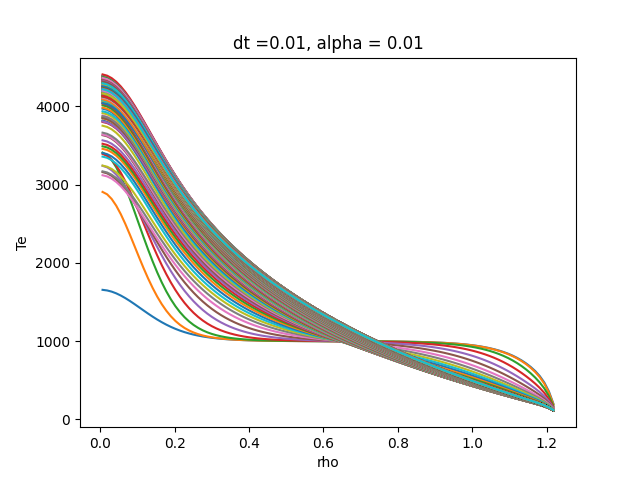

Text(0.5, 1.0, 'dt =0.01, alpha = 0.01')

In [5]:
if plots: viewer = Viewer(vars=(Te), title='Heating power = %0.3e W\nchi = %s' % (Qe.cellVolumeAverage.value * V, chi), datamin=0, datamax=5000)

plt.figure()

chi_run = chi
l1_c = x1/10
x1_c = x1/10

Te_history = []
runs = {}
for N in np.arange(0,NITER):
    eqI = TransientTerm(coeff=scipy.constants.e*ne*1.5) == DiffusionTerm(coeff=scipy.constants.e*ne*chi_run) + Qe
    eqI.solve(var=Te, dt=dt)
    if plots: viewer.plot()
    plt.plot(mesh.cellCenters.value[0], Te.value)
    Te_history.append(Te.value.copy())
    Gd = -np.gradient(Te.value, mesh.cellCenters.value[0]) * ne.value * eV
    runs[N] = {}
    runs[N]['x'], runs[N]['mean'], runs[N]['std'], runs[N]['xrange'], runs[N]['x1'], runs[N]['x2'] = ComPat.randomize(N1, N2, N3, l1=l1_c, l2=l2, l3=l3, s2=s2, s3=s3, d2=d2, d3=d3, x1=x1_c, x2=x2, alpha=alpha)
    x1_c = runs[N]['x1']
    l1_c = x1_c
#    runs[N]['chi'] = 10 ** runs[N]['x1'] / Gd[Gd.shape[0]//2]
    runs[N]['chi'] = 10 ** runs[N]['x1'] / Gi[Gi.shape[0]//2]
    chi_run = runs[N]['chi']
plt.xlabel('rho')
plt.ylabel('Te')
plt.title('dt =%s, alpha = %s' % (dt, alpha))

We plot the history of the central Te versus iteration number

<IPython.core.display.Javascript object>


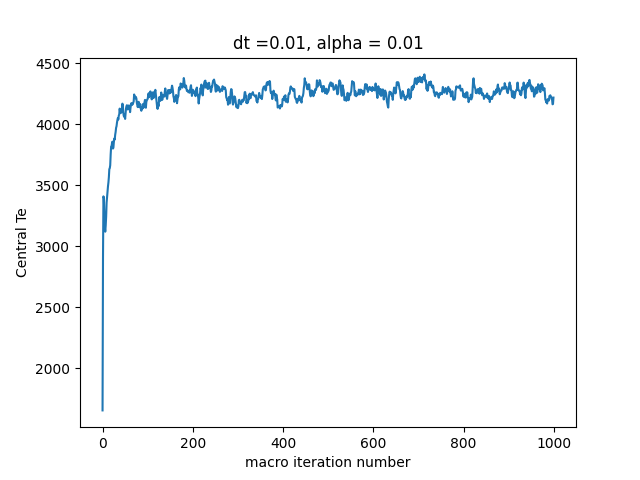

(1000, 100)


In [6]:
plt.figure()
Te_all = np.array(Te_history)
print(Te_all.shape)
plt.plot(Te_all[:,0])
plt.xlabel('macro iteration number')
plt.ylabel('Central Te')
plt.title('dt =%s, alpha = %s' % (dt, alpha))
plt.savefig('Te_0_dt=%s_alpha=%s.png' % (dt, alpha))

We plot the (stochastized) flux versus the iteration number, together with steady state "target" flux (determined by integration of the source term).

<IPython.core.display.Javascript object>


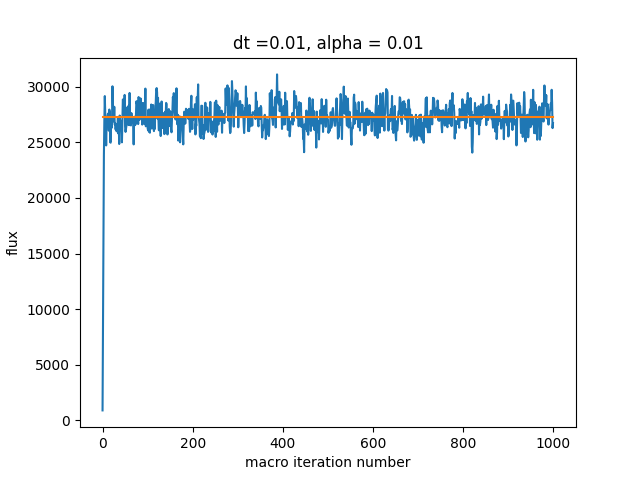

Text(0.5, 1.0, 'dt =0.01, alpha = 0.01')

In [7]:
plt.figure()
plt.plot(10**np.array([r['x1'] for r in runs.values()]))
plt.xlabel('macro iteration')
plt.ylabel('flux')
plt.plot([0,NITER], [10**x1, 10**x1])
plt.xlabel('macro iteration number')
plt.ylabel('flux')
plt.title('dt =%s, alpha = %s' % (dt, alpha))

Histogram of the central Te over the complete set of iterations

<IPython.core.display.Javascript object>


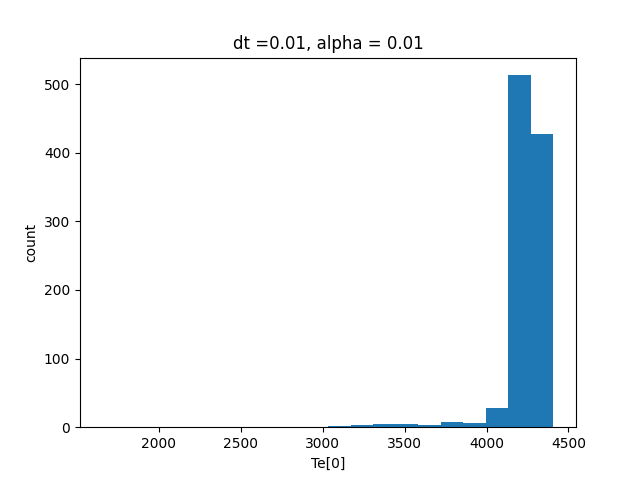

4232.503336357835 160.52425853856303


In [8]:
plt.figure()
plt.hist(Te_all[:,0], bins=20)
plt.xlabel('Te[0]')
plt.ylabel('count')
plt.title('dt =%s, alpha = %s' % (dt, alpha))
print(np.mean(Te_all, axis=0)[0], np.std(Te_all, axis=0)[0])

Histogram of the central Te over the last 500 iterations

<IPython.core.display.Javascript object>


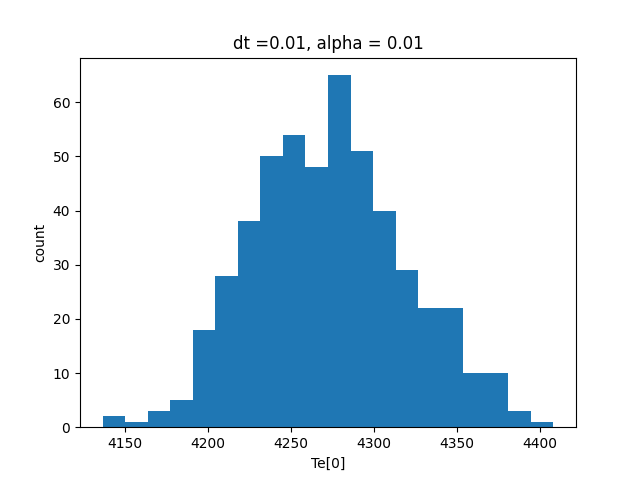

4264.277343957643 50.81235945547257


In [9]:
plt.figure()
plt.hist(Te_all[500:,0], bins=20)
plt.xlabel('Te[0]')
plt.ylabel('count')
plt.title('dt =%s, alpha = %s' % (dt, alpha))
print(np.mean(Te_all[100:], axis=0)[0], np.std(Te_all[100:], axis=0)[0])